In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
tf.set_random_seed(1234)
np.random.seed(100)

In [3]:
print(tf.__version__)
print(np.__version__)

1.4.0
1.12.0


In [4]:
# References
# Hugo Larochelle: https://www.youtube.com/watch?v=t2NQ_c5BFOc
# https://github.com/surfertas/chainer-tutorials/blob/master/06_autoencoder.py
# https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/autoencoder.py

In [5]:
def visualize_image(images):
    """Helper function for visualizing reconstructions.
    Params:
        images: array images to process.
    """
    dim = images.shape[0]
    n_image_rows = int(np.ceil(np.sqrt(dim)))
    n_image_cols = int(np.ceil(dim * 1.0 / n_image_rows))
    gs = gridspec.GridSpec(n_image_rows, n_image_cols, top=1., bottom=0.,
                           right=1., left=0., hspace=0., wspace=0.)

    for g, count in zip(gs, range(int(dim))):
        ax = plt.subplot(g)
        ax.imshow(images[count, :].astype(np.float32).reshape((28, 28)))
        ax.set_xticks([])
        ax.set_yticks([])
 

In [6]:
class DenoiseAutoEncoder(object):
    
    def __init__(self, sess, n_inputs, n_h1, n_h2, corrupt, epochs, batch_size):
        self._sess = sess
        self._n_inputs = n_inputs
        self._n_h1 = n_h1
        self._n_h2 = n_h2
        self._corrupt = corrupt
        self._epochs = epochs
        self._batch_size = batch_size
        self._build_graph()

    def _model(self, x):
        def encoder(x_):
            # Encode the input from dimensions 784 to 256 to 64.
            out = tf.layers.dense(x_, self._n_h1, tf.nn.sigmoid)
            out = tf.layers.dense(out, self._n_h2, tf.nn.sigmoid)
            return out
        
        def decoder(x_):
            # Decode x_ of size 64 to 256 to 784.
            out = tf.layers.dense(x_, self._n_h1, tf.nn.sigmoid)
            out = tf.layers.dense(out, self._n_inputs, tf.nn.sigmoid)
            return out
        
        return decoder(encoder(x))
    
    def _get_corrupted_input(self, x):
        # Returns the corrupted version of the input x.
        mask = np.random.RandomState(1).binomial(
            size=self._n_inputs, n=1, p=(1. - self._corrupt)
        )
        return mask.astype(np.float32) * x

    def _build_graph(self):
        self._inputs = tf.placeholder("float", [None, self._n_inputs])

        # Prediction is the resulted of encoding then decoding.
        self._pred = self._model(self._inputs)
        
        # Target is the corrupted input.
        self._targets = self._get_corrupted_input(self._inputs)

        self._loss = tf.losses.mean_squared_error(self._targets, self._pred)
        
        # Use Adam with default settings for hyperparameters.
        self._optimizer = tf.train.AdamOptimizer().minimize(self._loss)
        
    
    def train(self, data_set):
        tf.global_variables_initializer().run()
        total_num_steps = len(data_set.train.images)/self._batch_size
        for epoch in range(self._epochs):
            epoch_loss = 0
            for step in range(total_num_steps):
                batch_img, _ = data_set.train.next_batch(self._batch_size)

                loss, _ = self._sess.run([self._loss, self._optimizer], feed_dict={
                    self._inputs: batch_img}
                )
                epoch_loss += loss/total_num_steps
                
            print("Epoch: {} Loss: {}".format(epoch, epoch_loss))
            

    def evaluate(self, data_set):
        batch_img, _ = data_set.test.next_batch(4)
        images = self._sess.run(self._pred, feed_dict={
            self._inputs: batch_img}
        )
        return batch_img, images
        
    
    

In [7]:
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

n_input = 28 * 28
n_hidden_1 = 256
n_hidden_2 = 64
corruption = 0.3
epochs = 5
batch_size = 32


with tf.Session() as sess:
    model = DenoiseAutoEncoder(sess, n_input, n_hidden_1, n_hidden_2, corruption, epochs, batch_size)
    model.train(mnist)
    original, predicted = model.evaluate(mnist)
    

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Epoch: 0 Loss: 0.034591855826
Epoch: 1 Loss: 0.0189445853684
Epoch: 2 Loss: 0.0140000997335
Epoch: 3 Loss: 0.0111186392421
Epoch: 4 Loss: 0.00923964296895


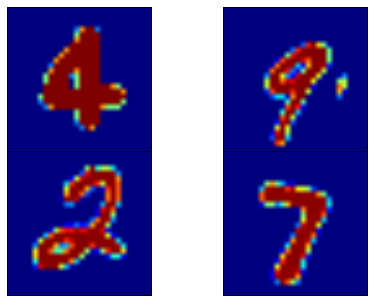

In [8]:
visualize_image(original)


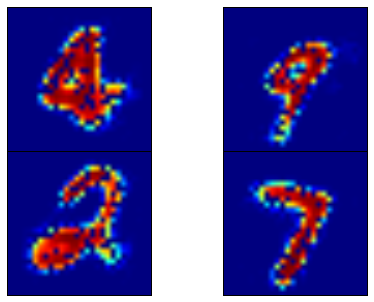

In [9]:
visualize_image(predicted)